In [2]:
from openhsl.hsi import HSImage
from openhsl.hs_mask import HSMask
from openhsl.models.m1dcnn import M1DCNN
from openhsl.models.ssftt import SSFTT
from openhsl.data.utils import convert_to_color_
from openhsl.utils import draw_fit_plots

from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import numpy as np

import torch
import math
import pandas as pd

### Загрузим тестовый набор данных

In [4]:
hsi = HSImage()
mask = HSMask()

#hsi.load_from_mat('./test_data/tr_pr/PaviaU.mat', mat_key='paviaU')
#mask.load_mask('./test_data/tr_pr/PaviaU_gt.mat', mat_key='paviaU_gt')

hsi.load('./pca_corn_1.mat', key='image')
mask.load('./test_data/tr_pr/mask_corn_1.mat', key='img')

void mask


### Зададим параметры обучения

In [10]:
optimizer_params = {
    "learning_rate": 0.001,
    "weight_decay": 0
}

fit_params = {
    "epochs": 3,
    'train_sample_percentage': 0.5,
    "dataloader_mode": "fixed",
    "optimizer_params": optimizer_params,
    "batch_size": 32
}

### Создадим объект нейросетевого классификатора

Требуется указывать количество классов (n_classes), которые будут предсказываться и количество спектральных каналов (n_bands).

Для применения PCA требуется указать количество главных компонент в n_bands и поставить флаг True в параметре apply_pca.

Для загрузки весов предобученной модели требуется указать путь до них в параметре path_to_weights

Список доступных моделей из пакета openhsl.models
- baseline.BASELINE
- hsicnn.HSICNN
- m1dcnn.M1DCNN
- m3dcnn_hamida.M3DCNN
- m3dcnn_he.M3DCNN
- m3dcnn_li.M3DCNN
- m3dcnn_sharma.M3DCNN
- nm3dcnn.NM3DCNN
- tf2dcnn.TF2DCNN

In [6]:
cnn = SSFTT(n_classes=mask.n_classes,
             n_bands=hsi.data.shape[-1],
             #n_bands=30,
             #apply_pca=True,
             #path_to_weights='../tests/checkpoints/nm3_dcnn__net/m3dcnn/2023_05_25_10_30_06_epoch3_0.85.pth',
             device='cuda')

### Обучение классификатора производится вызовом встроенного метода fit

In [ ]:
cnn.fit(X=hsi,
        y=mask,
        fit_params=fit_params)

PCA will not apply
Sampling fixed with train size = 0.5
Sampling fixed with train size = 0.9


Train loop:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

### Отрисуем графики обучения

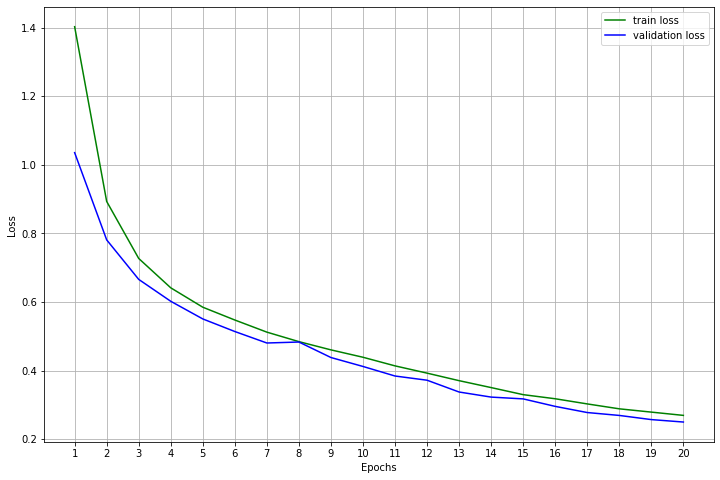

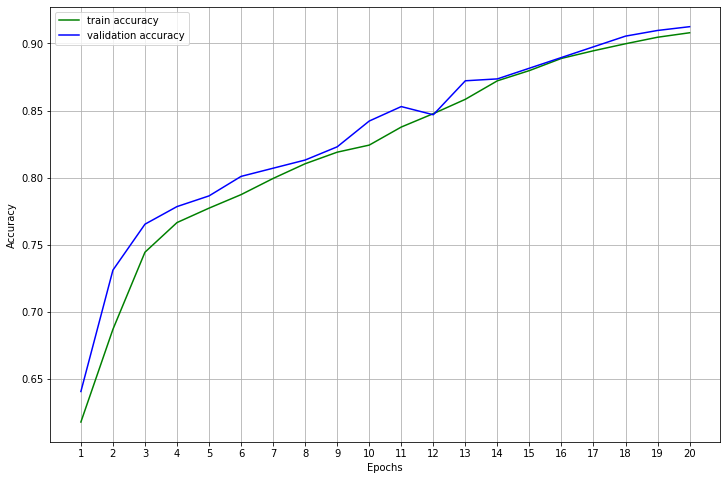

In [17]:
draw_fit_plots(model=cnn)

### Инференс классификатора производится вызовом встроенного метода predict

In [9]:
pred = cnn.predict(X=hsi, y=mask)

# Отобразим только размеченные области
pred = pred * (mask.get_2d() > 0)

PCA will not apply


Inference on the image: 100%|█████████████████████████████████████████████████████| 2074/2074 [00:02<00:00, 788.24it/s]


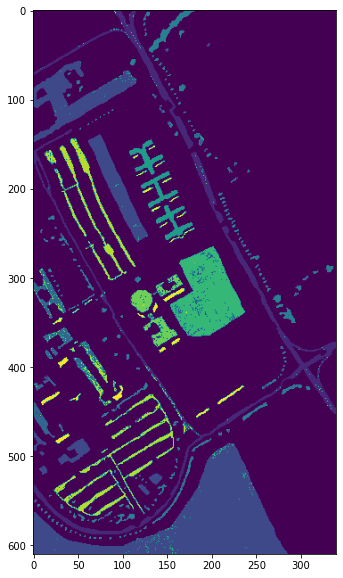

In [10]:
# Отрисуем результат инференса
plt.figure(figsize=(10,10))
plt.imshow(pred)
plt.show()

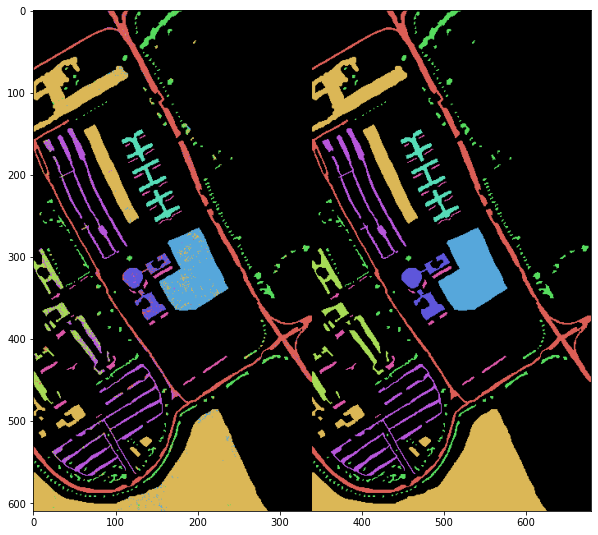

In [11]:
# Для большей наглядности раскрасим маски и отрисуем результат инференса (слева) вместе с эталоном (справа)

color_pred = convert_to_color_(pred)

plt.figure(figsize=(10,10))
plt.imshow(np.hstack((color_pred, convert_to_color_(mask.get_2d()))))
plt.show()

In [12]:
# Получим метрики классификации
report = classification_report(mask.get_2d().flatten(), pred.flatten(), output_dict=True)

In [13]:
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,164624.000000
1,0.956826,0.969235,0.962991,6631.000000
2,0.969033,0.988310,0.978577,18649.000000
3,0.919977,0.750357,0.826555,2099.000000
4,0.989328,0.907637,0.946723,3064.000000
5,0.998513,0.998513,0.998513,1345.000000
6,0.956768,0.941738,0.949193,5029.000000
7,0.963364,0.869925,0.914263,1330.000000
8,0.846834,0.936991,0.889634,3682.000000
9,0.997886,0.996832,0.997359,947.000000
